# Курсовой проект на тему: 'Исследование эффективности различных методов оптимизации гиперпараметров в задачах машинного обучения'

Цель проекта: рассмотреть различные методы оптимизации гиперпараметров на примере реального датасета. Выявить оптимальный способ на примере популярных алгоритмов машинного обучения: DecisionTreeClassifier и KNeighborsClassifier.

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
from sklearn.model_selection import *
from sklearn.tree import *
import time
from sklearn.svm import *
from sklearn.neighbors import *
from skopt import *
import optuna
from hyperopt import *
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

Загрузим все нужные библиотеки, которые будем использовать в проекте.

В рамках работы над проектом был выбран датасет с данными о циррозе печени, предоставленный клиникой Мейо. Данные содержат информацию о первичном билиарном циррозе печени у пациентов с 1974 по 1984 года.

Ставится задача классификации. В нашем случае: предсказать статус пациента (сами статусы будут рассмотрены далее). Датасет содержит информацию по некоторым медицинским показателям, которые влияют на болезнь печени, а также некоторые данные о самом пациенте.

Загрузим датасет и проанализируем полученные данные.

In [3]:
data = pd.read_csv('liver_cirrhosis.csv')
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [4]:
data.shape

(25000, 19)

Заметим, что у нас есть 19 столбцов. Status - целевая переменная, отвечающая за статус пациента, либо пациент находится на обследовании, либо пациент находится на обследовании после пересадки печени, либо пациент мёртв.

Остальные столбцы будут использованы в качестве признаков. Часть из них (как и целевая переменная) представлены в качестве категориальных атрибутов (Drug, Sex, Ascites, Hepatomegaly, Spiders, Edema). 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [6]:
data.describe(include='all')

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000,25000,25000.000000,25000,25000,25000,25000,25000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
unique,NaN,3,2,NaN,2,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,C,Placebo,NaN,F,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,13516,15827,NaN,22137,16798,15243,13614,20220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1887.117040,NaN,NaN,18495.877080,NaN,NaN,NaN,NaN,NaN,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,NaN,NaN,3737.596616,NaN,NaN,NaN,NaN,NaN,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,NaN,NaN,9598.000000,NaN,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,NaN,NaN,15694.000000,NaN,NaN,NaN,NaN,NaN,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,NaN,NaN,18499.000000,NaN,NaN,NaN,NaN,NaN,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,NaN,NaN,20955.000000,NaN,NaN,NaN,NaN,NaN,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000


In [7]:
data.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

Рассмотрим информацию по каждому атрибуту:

N_Days: Количество дней между регистрацией и более ранней датой смерти, трансплантации или времени анализа исследования в 1986 г. (кол-во дней)

Drug: тип препарата (бинарный: Placebo, D-penicillamine)

Age: возраст в днях (кол-во дней)

Sex: пол (бинарный: M(мужчина), F(женщина))

Ascites: наличие асцита (бинарный: Y(да) или N(нет))

Hepatomegaly: наличие гепатомегалии (бинарный: Y(да), N(нет))

Spiders: наличие "фигуры паука" (бинарный: Y(да), N(нет))

Edema: наличие отеков (N(нет отеков и нет терапии диуретиками), S(отеки присутствуют без терапии диуретиками или  разрешаются диуретиками), Y(отеки присутствуют несмотря на терапию диуретиками))

Bilirubin: билирубин в [mg/dl]

Cholesterol: холестерол в [mg/dl]

Albumin: альбумины в [gm/dl]

Copper: медь в [ug/day]

Alk_Phos: щелочная фосфатаза в [U/liter]

SGOT: АсАТ в [U/ml]

Tryglicerides: жиры в [mg/dl]

Platelets: тромбоциты [ml/1000]

Prothrombin: протромбин в секундах (сек)

Stage: стадия заболевания (1, 2, 3)

Возраст в данных указан в днях, в нашем случае перевод в года будет нецелесообразным. Для того, чтобы не терять точность оставим данные в таком представлении.

Показатели являются составляющими при изучении заболевания цирроза печени, поэтому на данном этапе оставим их все.

Отметим, что данные не содержат пропущенных значений. Также при выводе информации аномальных значений на данном этапе также не замечено.

Рассмотрим целевую переменную.

In [8]:
data['Status'].unique()

array(['C', 'D', 'CL'], dtype=object)

In [9]:
data.Status.value_counts()

Status
C     13516
D      9456
CL     2028
Name: count, dtype: int64

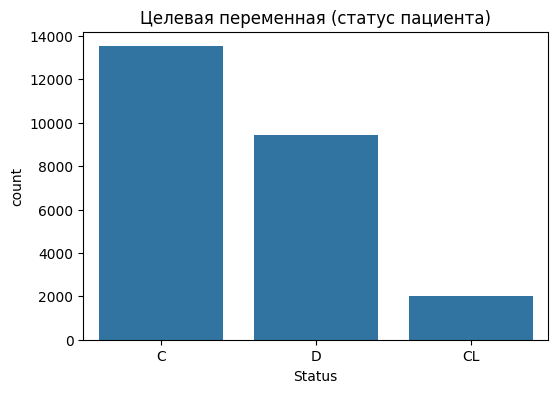

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Status', data=data)
plt.title('Целевая переменная (статус пациента)')
plt.show()

Заметим, что статус CL(обследование после пересадки печени) по сравнению с остальными составляет меньшинство. Для того, чтобы избежать дисбаланс классов, следует объединить статусы C и CL, поскольку они являются полным противовесом статуса D(смерть) и содержат в себе смысл обследования.

In [11]:
data.Status.replace({"C": 1, "CL": 1, "D": 0}, inplace=True)

In [12]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,1,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,1,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,1,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,0,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,0,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [13]:
data.Status.value_counts()

Status
1    15544
0     9456
Name: count, dtype: int64

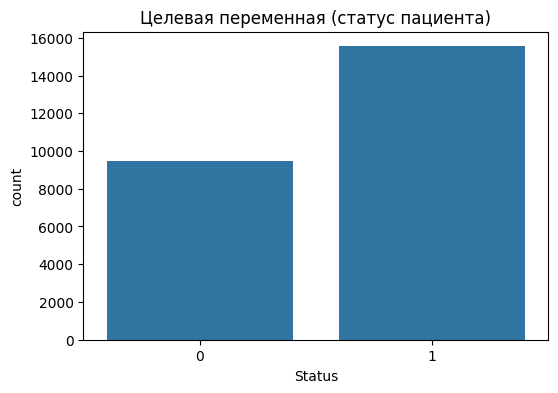

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Status', data=data)
plt.title('Целевая переменная (статус пациента)')
plt.show()

Здесь 1 - пациент находится на обследовании, 0 - пациент мёртв (по причине цирроза печени).

Рассмотрим категориальные атрибуты, с помощью Хи-теста проверим их на влияние на целевую переменную (H0: нет зависимости с целевой переменной) и переведем в численные значения.

In [15]:
data['Drug'].unique()

array(['Placebo', 'D-penicillamine'], dtype=object)

In [16]:
data.Drug.value_counts()

Drug
Placebo            15827
D-penicillamine     9173
Name: count, dtype: int64

In [17]:
chi_drug = chi2_contingency(pd.crosstab(data['Status'], data['Drug']))
print(f'Нулевая гипотеза отвергается: {chi_drug[1] < 0.05}')

Нулевая гипотеза отвергается: False


Следовательно, тип принимаемого препара не влияет на целевую переменную, можем исключить данный столбец из рассмотрения.

In [18]:
data = data.drop(columns='Drug')

In [19]:
data['Sex'].unique()

array(['F', 'M'], dtype=object)

In [20]:
data.Sex.value_counts()

Sex
F    22137
M     2863
Name: count, dtype: int64

In [21]:
chi_sex = chi2_contingency(pd.crosstab(data['Status'], data['Sex']))
print(f'Нулевая гипотеза отвергается: {chi_sex[1] < 0.05}')

Нулевая гипотеза отвергается: True


Следовательно, данный атрибут полезен и его следует оставить. Посмотрим его зависимость на целевую переменную:

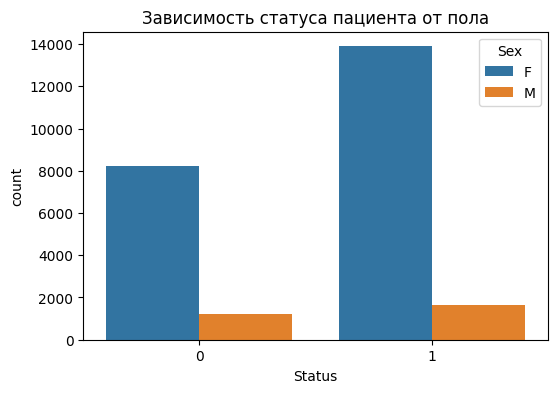

In [22]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Sex')
plt.title('Зависимость статуса пациента от пола')
plt.show()

По диграмме видно, что мужчин заболевших циррозом печени во много больше, чем женщин.

Заменим значение F на 0 и M на 1 для дальнейшего использования в работе.

In [23]:
data.Sex.replace({"M": 1, "F": 0}, inplace=True)

In [24]:
data['Ascites'].unique()

array(['N', 'Y'], dtype=object)

In [25]:
data.Ascites.value_counts()

Ascites
N    16798
Y     8202
Name: count, dtype: int64

In [26]:
chi_ascites = chi2_contingency(pd.crosstab(data['Status'], data['Ascites']))
print(f'Нулевая гипотеза отвергается: {chi_ascites[1] < 0.05}')

Нулевая гипотеза отвергается: True


Данный атрибут является значимым, соответственно, оставим его в таблице. Посмотрим его зависимость на целевую переменную:

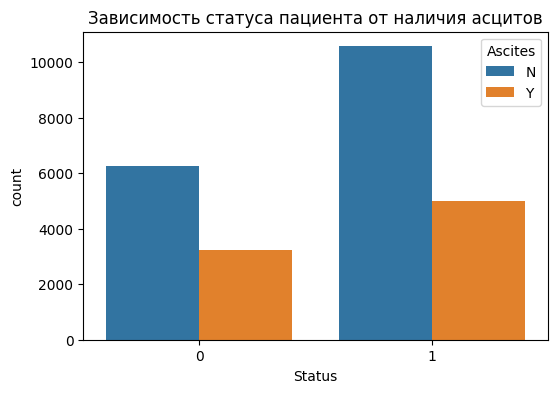

In [27]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Ascites')
plt.title('Зависимость статуса пациента от наличия асцитов')
plt.show()

У большого количества пациентов, находящихся на обследовании, нет асцитов. Но в то же время, у половины обследумых подтверждается их наличие. Заменим наличие на 1, а отсутствие на 0.

In [28]:
data.Ascites.replace({"Y": 1, "N": 0}, inplace=True)

In [29]:
data['Hepatomegaly'].unique()

array(['Y', 'N'], dtype=object)

In [30]:
data.Hepatomegaly.value_counts()

Hepatomegaly
N    15243
Y     9757
Name: count, dtype: int64

In [31]:
chi_hepa = chi2_contingency(pd.crosstab(data['Status'], data['Hepatomegaly']))
print(f'Нулевая гипотеза отвергается: {chi_hepa[1] < 0.05}')

Нулевая гипотеза отвергается: True


Следовательно, сохраняем атрибут, поскольку он также имеет значимость. Рассмотрим зависимость с целевой переменной:

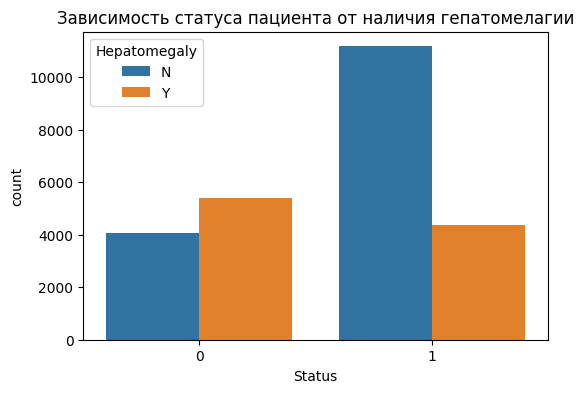

In [32]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Hepatomegaly')
plt.title('Зависимость статуса пациента от наличия гепатомелагии')
plt.show()

Отметим, что у обследуемых пациентов преобладает отсуствие гепатомегалии. В то же время уровень наличия гепатомегаллии у обоих статусов примерно одинаковый. Также можем заменить Y на 1 и N на 0.

In [33]:
data.Hepatomegaly.replace({"Y": 1, "N": 0}, inplace=True)

In [34]:
data['Spiders'].unique()

array(['N', 'Y'], dtype=object)

In [35]:
data.Spiders.value_counts()

Spiders
N    13614
Y    11386
Name: count, dtype: int64

In [36]:
chi_spiders = chi2_contingency(pd.crosstab(data['Status'], data['Spiders']))
print(f'Нулевая гипотеза отвергается: {chi_spiders[1] < 0.05}')

Нулевая гипотеза отвергается: True


Данный атрибут является значимым, поэтому оставим его для дальнейшего исследования. Рассмотрим влияние на целевую переменную: 

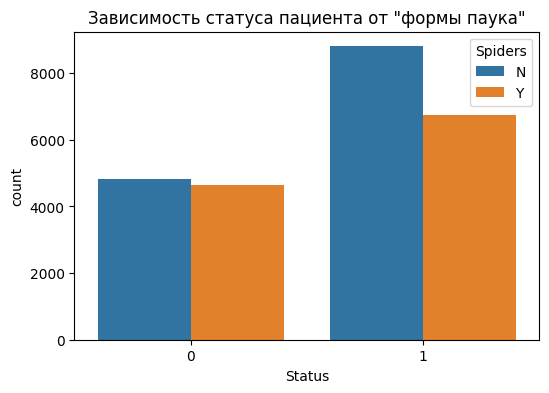

In [37]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Spiders')
plt.title('Зависимость статуса пациента от "формы паука"')
plt.show()

У пациентов, проходящих обследование, преобладает отсуствие "формы паука". В другом классе оба показателя примерно равные. Также заменим наличие на 1, отсуствие - на 0.

In [38]:
data.Spiders.replace({"Y": 1, "N": 0}, inplace=True)

In [39]:
data['Edema'].unique()

array(['N', 'Y', 'S'], dtype=object)

In [40]:
data.Edema.value_counts()

Edema
N    20220
S     3698
Y     1082
Name: count, dtype: int64

In [41]:
chi_edema = chi2_contingency(pd.crosstab(data['Status'], data['Edema']))
print(f'Нулевая гипотеза отвергается: {chi_edema[1] < 0.05}')

Нулевая гипотеза отвергается: True


Следует оставить данный атрибут, поскольку он влияет на целевую переменную. Рассмотрим влияние:

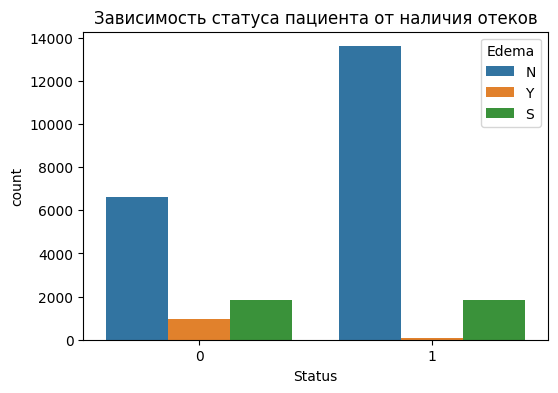

In [42]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Edema')
plt.title('Зависимость статуса пациента от наличия отеков')
plt.show()

Отметим, что у обследуемых пациентов почти нет отеков. 

Заметим, что отсуствие является преобладающим среди обоих классов. Также для темы исследования не важно происхождение отеков, поэтому следует выделить два класса: 1 - отеки есть, 0 - отеков нет. Выделять отдельные столбцы для этого будет нецелесообразно.

In [43]:
data.Edema.replace({"Y": 1, "S": 1, "N": 0}, inplace=True)

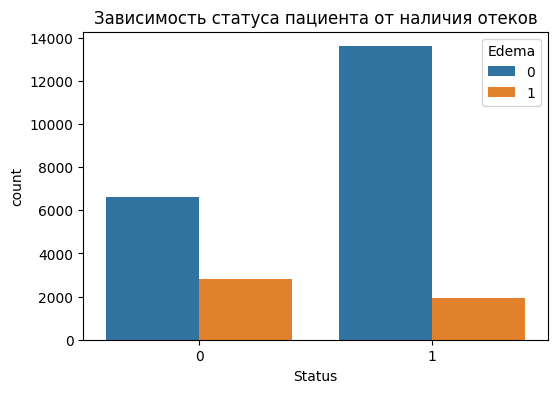

In [44]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Edema')
plt.title('Зависимость статуса пациента от наличия отеков')
plt.show()

In [45]:
data['Stage'].unique()

array([1, 2, 3])

In [46]:
data.Stage.value_counts()

Stage
2    8441
3    8294
1    8265
Name: count, dtype: int64

In [47]:
chi_stage = chi2_contingency(pd.crosstab(data['Status'], data['Stage']))
print(f'Нулевая гипотеза отвергается: {chi_stage[1] < 0.05}')

Нулевая гипотеза отвергается: True


Следовательно, данный признак влияет на целевую переменную и его стоит оставить. Рассмотрим на графике:

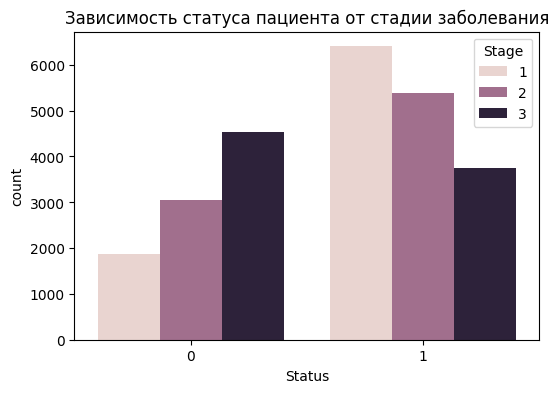

In [48]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='Status', data=data, hue='Stage')
plt.title('Зависимость статуса пациента от стадии заболевания')
plt.show()

Получили зависимость: чем больше стадия, тем больше смертность.

Рассмотрим числовые атрибуты, в особенности корреляцию между ними.

In [49]:
num_atr=['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin' , 'Copper', 'Alk_Phos', 'SGOT', 
     'Tryglicerides', 'Platelets', 'Prothrombin']

In [50]:
corr = data[num_atr]
corr_matrix = corr.corr(method='pearson')
corr_matrix

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
N_Days,1.000000,-0.060569,-0.394799,-0.123461,0.368851,-0.281349,0.147792,-0.220532,-0.147606,0.115908,-0.149960
Age,-0.060569,1.000000,0.006081,-0.035932,-0.108807,0.006670,0.029575,0.011165,0.030719,-0.123611,0.042134
Bilirubin,-0.394799,0.006081,1.000000,0.339106,-0.283105,0.432199,0.112972,0.368024,0.379776,-0.095162,0.254145
Cholesterol,-0.123461,-0.035932,0.339106,1.000000,-0.066418,0.129223,0.116131,0.322450,0.248305,0.008835,0.006194
Albumin,0.368851,-0.108807,-0.283105,-0.066418,1.000000,-0.179171,-0.125686,-0.162569,-0.111661,0.118662,-0.215859
Copper,-0.281349,0.006670,0.432199,0.129223,-0.179171,1.000000,0.200772,0.281353,0.253358,-0.074730,0.141349
Alk_Phos,0.147792,0.029575,0.112972,0.116131,-0.125686,0.200772,1.000000,0.151769,0.129874,0.007922,0.072392
SGOT,-0.220532,0.011165,0.368024,0.322450,-0.162569,0.281353,0.151769,1.000000,0.122173,-0.093752,0.133210
Tryglicerides,-0.147606,0.030719,0.379776,0.248305,-0.111661,0.253358,0.129874,0.122173,1.000000,-0.020636,0.027211
Platelets,0.115908,-0.123611,-0.095162,0.008835,0.118662,-0.074730,0.007922,-0.093752,-0.020636,1.000000,-0.156356


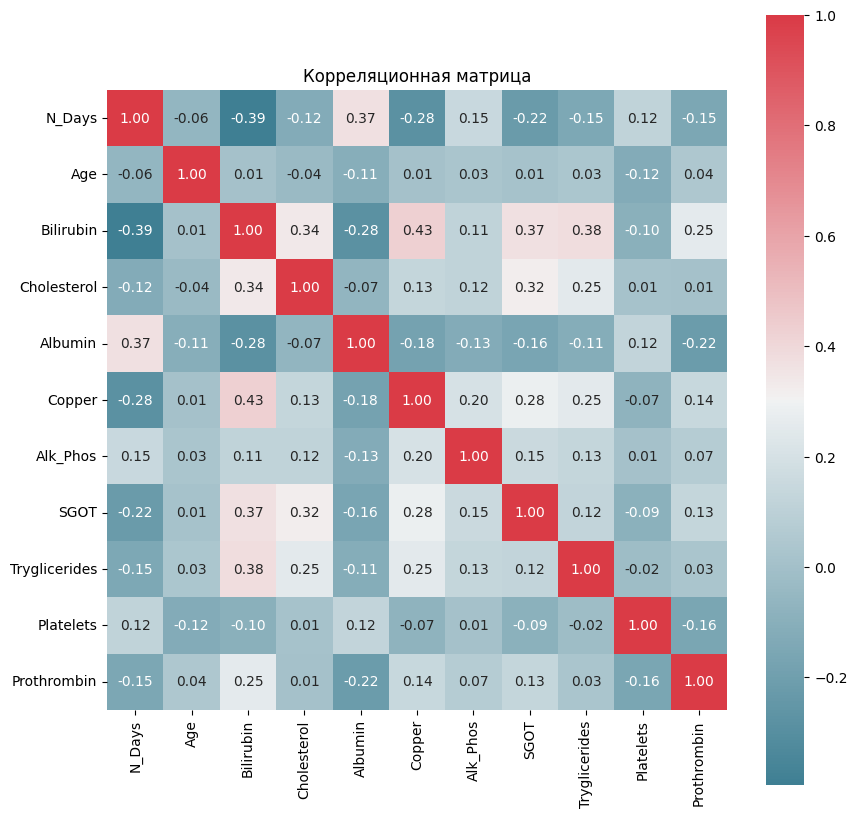

In [51]:
fig, ax =plt.subplots(figsize=(10, 10))
plt.title('Корреляционная матрица')
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, fmt=".2f")
plt.show()

Отметим, что сильной корреляции нет ни между какими атрибутами, значит лучше оставить все и продолжить иссоледования с ними.

В итоге после всех преобразований получим такую таблицу с данными, дальше можем переходить к исследованию.

In [52]:
data.head()

,N_Days,Status,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,1,18499,0,0,1,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,1,19724,1,1,0,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,1,11839,0,0,0,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,0,16467,0,0,0,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,0,21699,0,0,1,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


Выделим в отдельный столбце целевую переменную, затем поделим на тестовую и обучающую выборки (метод разделения - случайный, поскольку данные не являются временными или последовательными). Размер тестовой выборки будет 0.2, что является классическим.

In [102]:
y = data['Status']
X = data.drop(columns='Status')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Теперь можно перейти к построению моделей и оптимизации их гиперпараметров. Будут рассмотрены следующие алгоритмы: DecisionTreeClassifier, KNeighborsClassifier. Для каждого алгоритма мы будем использовать несколько методов оптимизации. Дальше все полученные результаты будут выгружены в таблицу для оценки эффективности каждого из методов для разных алгоритмов. Оцениваться эффективность будет с помощью кросс-валидации (метрики accuracy, precision, recall) и времени.

In [55]:
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()

Для каждого алгоритма подберем несколько гипермараметров и запишем их в виде словаря.

In [56]:
param1 = { 
    'max_features': ['sqrt', 'log2'],
    'min_samples_split':[2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}
param2 = { 'n_neighbors' : [5, 6, 7 , 8, 9, 10],
               'weights' : ['uniform', 'distance'],
               'metric' : ['minkowski','euclidean','manhattan']
}

Стоит начать с самого простого и распространнего способа оптимизации гиперпараметров - GridSearch. Все наборы значений просто перебираются, далее для каждой комбинации проводится обучение и оценивается ее эффективность на валидационных данных.

Данный метод в конечном итоге представляет хороший результат, но это очень ресурсозатратно по времени.

In [57]:
start_dt_gs= time.time()
grid_search1 = GridSearchCV(model1, param1, cv=5).fit(X_train, y_train)
end_dt_gs = time.time()
dt_best_params = grid_search1.best_params_
dt_best_score = grid_search1.best_score_
print('Набор гиперпараметров для Decision Tree: ', dt_best_params)

Набор гиперпараметров для Decision Tree:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}


In [58]:
start_knn_gs= time.time()
grid_search2 = GridSearchCV(model2, param2, cv=5).fit(X_train, y_train)
end_knn_gs = time.time()
knn_best_params = grid_search2.best_params_
knn_best_score = grid_search2.best_score_
print('Набор гиперпараметров для KNN: ', knn_best_params)

Набор гиперпараметров для KNN:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


Используя полученные комбинации гиперпараметров проведем отдельную кросс-валидацию для тестовой выборки.

In [59]:
cv1 = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='sqrt', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv1

0.8844

In [60]:
cv2 = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv2

0.9054

Еще один распространенный метод оптимизации - RandomizedSearchCV. Он работает быстрее предыдущего, поскольку не перебирает каждый набор, а выбирает рандомные. Однако всегда есть шанс пропустить некоторые комбинации гиперпараметров.

In [61]:
start_dt_rs = time.time()
random_search1 = RandomizedSearchCV(model1, param_distributions=param1, cv=5).fit(X_train, y_train)
end_dt_rs = time.time()
dt_best_params2 = random_search1.best_params_
dt_best_score2 = random_search1.best_score_
print('Набор гиперпараметров для Decision Tree: ', dt_best_params2)

Набор гиперпараметров для Decision Tree:  {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}


In [62]:
start_knn_rs = time.time()
random_search2 = RandomizedSearchCV(model2, param_distributions=param2, cv=5).fit(X_train, y_train)
end_knn_rs = time.time()
knn_best_params2 = random_search2.best_params_
knn_best_score2 = random_search2.best_score_
print('Набор гиперпараметров для KNN: ', knn_best_params2)

Набор гиперпараметров для KNN:  {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}


Тоже проведем отдельную кросс-валидацию для тестовой выборки на полученных данных.

In [63]:
cv3 = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt', min_samples_split=2, min_samples_leaf=4), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv3

0.8868

In [64]:
cv4 = cross_val_score(KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv4

0.8997999999999999

Существует метод, сочитающий в себе вероятностные модели с методами оптимизации, чтобы находить наилучшую комбинацию гиперпараметров - BayesSearchCV. Сам метод заключается в моделировании функции оценки производительности модели и в дальнейшем использования этой модели для выбора следующей точки для оценки. BayesSearchCV обычно требует меньше итераций для достижения наилучшего результата. 

In [65]:
start_dt_bs = time.time()
bayes_search1 = BayesSearchCV(model1, param1, n_iter=20, cv=5).fit(X_train, y_train)
end_dt_bs = time.time()
dt_best_params3 = bayes_search1.best_params_
dt_best_score3 = bayes_search1.best_score_
print('Набор гиперпараметров для Decision Tree: ', dt_best_params3)

Набор гиперпараметров для Decision Tree:  OrderedDict([('criterion', 'gini'), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_leaf', 5), ('min_samples_split', 4)])


In [66]:
start_knn_bs = time.time()
bayes_search2 = BayesSearchCV(model2, param2, n_iter=20, cv=5).fit(X_train, y_train)
end_knn_bs = time.time()
knn_best_params3 = bayes_search2.best_params_
knn_best_score3 = bayes_search2.best_score_
print('Набор гиперпараметров для KNN: ', knn_best_params3)

Набор гиперпараметров для KNN:  OrderedDict([('metric', 'manhattan'), ('n_neighbors', 5), ('weights', 'distance')])


Найдем оценки через кросс-валидацию:

In [67]:
cv5 = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv5

0.8916000000000001

In [68]:
cv6 = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv6

0.9054

Следующий метод, который будем использовать - это оптимизация с помощью библиотеки Optuna. Она предоставляет высокоуровневый интерфейс для оптимизации с использованием адаптивного методологического пространства для эффективного поиска. Библиотекой поддерживаются разнообразные стратегии оптимизации гиперпараметров.

Работа с этой библиотекой происходит несколько иначе, если сравнивать с предыдущими методами.

In [69]:
def objective(trial):
    params = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    
    dt = DecisionTreeClassifier(**params)
    return cross_val_score(dt, X_train, y_train).mean()

start_dt_op = time.time()
study_dt1 = optuna.create_study(direction='maximize')
study_dt1.optimize(objective, n_trials=100)
end_dt_op = time.time()

dt_best_params1 = study_dt1.best_params
dt_best_value1 = study_dt1.best_value
print("Лучшие гиперпараметры для DecisionTree:", dt_best_params1)


[I 2024-05-12 22:54:36,745] A new study created in memory with name: no-name-85faf653-d565-4250-aa4d-7c1084f00ca1
[I 2024-05-12 22:54:36,800] Trial 0 finished with value: 0.79695 and parameters: {'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.79695.
[I 2024-05-12 22:54:36,866] Trial 1 finished with value: 0.89205 and parameters: {'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.89205.
[I 2024-05-12 22:54:36,902] Trial 2 finished with value: 0.7766 and parameters: {'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.89205.
[I 2024-05-12 22:54:36,959] Trial 3 finished with value: 0.867 and parameters: {'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best 

Лучшие гиперпараметры для DecisionTree: {'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}


In [70]:
def objective(trial):
    params = {
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 10),
        'metric': trial.suggest_categorical('metric', ['minkowski','euclidean','manhattan'])
    }
    
    knn = KNeighborsClassifier(**params)
    return cross_val_score(knn, X_train, y_train).mean()

start_knn_op = time.time()
study_knn1 = optuna.create_study(direction='maximize')
study_knn1.optimize(objective, n_trials=100)
end_knn_op = time.time()

knn_best_params1 = study_knn1.best_params
knn_best_value1 = study_knn1.best_value
print("Лучшие гиперпараметры для KNN:", knn_best_params1)

[I 2024-05-12 22:54:46,001] A new study created in memory with name: no-name-e774b06c-8f13-4d33-a3c7-78bde683e9a8
[I 2024-05-12 22:54:46,565] Trial 0 finished with value: 0.9126 and parameters: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'euclidean'}. Best is trial 0 with value: 0.9126.
[I 2024-05-12 22:54:46,878] Trial 1 finished with value: 0.9379 and parameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'minkowski'}. Best is trial 1 with value: 0.9379.
[I 2024-05-12 22:54:47,749] Trial 2 finished with value: 0.92485 and parameters: {'weights': 'uniform', 'n_neighbors': 6, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9379.
[I 2024-05-12 22:54:48,020] Trial 3 finished with value: 0.9379 and parameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean'}. Best is trial 1 with value: 0.9379.
[I 2024-05-12 22:54:48,556] Trial 4 finished with value: 0.9071000000000001 and parameters: {'weights': 'uniform', 'n_neighbors': 6, 'metric': 'minkowski'}. Be

Лучшие гиперпараметры для KNN: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}


Проведем кросс-валидацию только для DecisionTree, поскольку для KNN такой набор уже встречался ранее:

In [71]:
cv7 = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=4, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv7

0.8742000000000001

Еще одна библиотека, которую можно использовать для оптимизации, - hyperopt. Работает она с использованием байесовской оптимизации. Сам метод представляет собой моделирование функции оценки производительности и выбор следующего набора гиперпараметров на основе вероятностой модели. Гибкий подход данной библиотеки делает ее полезной для решения сложных задач.

In [72]:
param1_h = {
    'max_depth': hp.choice('max_depth', range(3, 8)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'min_samples_split': hp.choice('min_samples_split', range(2, 5)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

def objective(params):
    dt = DecisionTreeClassifier(**params)
    return cross_val_score(dt, X_train, y_train).mean()

hyperdt1 = 0
def hyperport_optimize(params):
    global hyperdt1
    accur = objective(params)
    if accur > hyperdt1:
      hyperdt1 = accur
      print('Result:', hyperdt1, params)
    return {'loss': -accur, 'status': STATUS_OK}

start_dt_h = time.time()
trials1 = Trials()
hyper_dt1 = fmin(hyperport_optimize, param1_h, algo=tpe.suggest, max_evals=100, trials=trials1)
end_dt_h = time.time()


Result:                                                
0.8376999999999999                                     
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4}
Result:                                                                           
0.8611000000000001                                                                
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3}
Result:                                                                           
0.8686499999999999                                                                 
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
Result:                                                                            
0.8750500000000001                                                                 
{'criterion': 'gini', 'max_depth': 7, 'max_features

In [73]:
param2_h = {
    'n_neighbors': hp.choice('n_neighbors', range(5, 10)),
    'metric': hp.choice('metric', ['minkowski','euclidean','manhattan']),
    'weights': hp.choice('weights', ['uniform', 'distance'])
}

def objective(params):
    knn = KNeighborsClassifier(**params)
    return cross_val_score(knn, X_train, y_train).mean()

hyperdt2 = 0
def hyperport_optimize(params):
    global hyperdt2
    accur = objective(params)
    if accur > hyperdt2:
      hyperdt2 = accur
      print('Result:', hyperdt2, params)
    return {'loss': -accur, 'status': STATUS_OK}

start_knn_h = time.time()
trials2 = Trials()
hyper_knn2 = fmin(hyperport_optimize, param2_h, algo=tpe.suggest, max_evals=100, trials=trials2)
end_knn_h = time.time()

Result:                                                
0.9359999999999999                                     
{'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'distance'}
Result:                                                                           
0.9379                                                                            
{'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}                  
Result:                                                                           
0.9502                                                                
{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}      
Result:                                                               
0.95045                                                               
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}      
100%|██████████| 100/100 [01:05<00:00,  1.54trial/s, best loss: -0.95045]


Также проверим кросс-валидацию только для Desicion Tree.

In [75]:
cv8 = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_split=2, min_samples_leaf=3), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'accuracy', 
                             n_jobs=-1).mean() 
cv8

0.8634000000000001

Также посмотрим кросс-валидацию с помощью других метрик (в нашем случае precision, recall).

In [116]:
cv1p = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='sqrt', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv2p = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv3p = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt', min_samples_split=2, min_samples_leaf=4), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv4p = cross_val_score(KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv5p = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv6p = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv7p = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=4, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

cv8p = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_split=2, min_samples_leaf=3), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'precision', 
                             n_jobs=-1).mean() 

In [117]:
cv1r = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='sqrt', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv2r = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv3r = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt', min_samples_split=2, min_samples_leaf=4), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv4r = cross_val_score(KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv5r = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=3, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv6r = cross_val_score(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv7r = cross_val_score(DecisionTreeClassifier(criterion='gini', max_depth=8, max_features='log2', min_samples_split=4, min_samples_leaf=1), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

cv8r = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_split=2, min_samples_leaf=3), 
                             X_test,            
                             y_test,    
                             cv = 5,        
                             scoring = 'recall', 
                             n_jobs=-1).mean() 

Соберем все полученные значения в две таблицы.

In [125]:
tree = pd.DataFrame(columns=['Name', 'Criterion', 'Max_depth', 'Max_features', 'Min_samples_split', 
                             'Min_samples_leaf', 'Best score', 'Cross val score', 'Time', 'Precision', 'Recall'])
neighbors = pd.DataFrame(columns=['Name', 'Metric', 'N_neighbors', 'Weights', 'Best score', 'Cross val score', 'Time', 'Precision', 'Recall'])

In [126]:
new_row1 = {'Name': 'GridSearch', 'Criterion': dt_best_params['criterion'], 'Max_depth': dt_best_params['max_depth'], 
                    'Max_features': dt_best_params['max_features'], 'Min_samples_split': dt_best_params['min_samples_split'],
                    'Min_samples_leaf': dt_best_params['min_samples_leaf'], 'Best score': dt_best_score,
                    'Cross val score': cv1, 'Time': end_dt_gs-start_dt_gs, 'Precision': cv1p, 'Recall': cv1r}

new_row2 = {'Name': 'RandomizedSearch', 'Criterion': dt_best_params2['criterion'], 'Max_depth': dt_best_params2['max_depth'], 
                    'Max_features': dt_best_params2['max_features'], 'Min_samples_split': dt_best_params2['min_samples_split'],
                    'Min_samples_leaf': dt_best_params2['min_samples_leaf'], 'Best score': dt_best_score2,
                    'Cross val score': cv3, 'Time': end_dt_rs-start_dt_rs, 'Precision': cv3p, 'Recall': cv3r}

new_row3 = {'Name': 'BayesSearch', 'Criterion': dt_best_params3['criterion'], 'Max_depth': dt_best_params3['max_depth'], 
                    'Max_features': dt_best_params3['max_features'], 'Min_samples_split': dt_best_params3['min_samples_split'],
                    'Min_samples_leaf': dt_best_params3['min_samples_leaf'], 'Best score': dt_best_score3,
                    'Cross val score': cv5, 'Time': end_dt_bs-start_dt_bs, 'Precision': cv5p, 'Recall': cv5r}

new_row4 = {'Name': 'Optuna', 'Criterion': dt_best_params1['criterion'], 'Max_depth': dt_best_params1['max_depth'], 
                    'Max_features': dt_best_params1['max_features'], 'Min_samples_split': dt_best_params1['min_samples_split'],
                    'Min_samples_leaf': dt_best_params1['min_samples_leaf'], 'Best score': dt_best_value1,
                    'Cross val score': cv7, 'Time': end_dt_op-start_dt_op, 'Precision': cv7p, 'Recall': cv7r}

new_row5 = {'Name': 'Hyperopt', 'Criterion': param1['criterion'][hyper_dt1['criterion']], 'Max_depth': param1['max_depth'][hyper_dt1['max_depth']], 
                    'Max_features': param1['max_features'][hyper_dt1['max_features']], 'Min_samples_split': param1['min_samples_split'][hyper_dt1['min_samples_split']],
                    'Min_samples_leaf': param1['min_samples_leaf'][hyper_dt1['min_samples_leaf']], 'Best score': hyperdt1,
                    'Cross val score': cv8, 'Time': end_dt_h-start_dt_h, 'Precision': cv8p, 'Recall': cv8r}

In [127]:
new_row6 = {'Name': 'GridSearch', 'Metric': knn_best_params['metric'], 'N_neighbors': knn_best_params['n_neighbors'],
             'Weights': knn_best_params['weights'], 'Best score': knn_best_score, 'Cross val score': cv2, 'Time': end_knn_gs-start_knn_gs,
             'Precision': cv2p, 'Recall': cv2r}

new_row7 = {'Name': 'RandomizedSearch', 'Metric': knn_best_params2['metric'], 'N_neighbors': knn_best_params2['n_neighbors'],
             'Weights': knn_best_params2['weights'], 'Best score': knn_best_score2, 'Cross val score': cv4, 'Time': end_knn_rs-start_knn_rs,
             'Precision': cv4p, 'Recall': cv4r}

new_row8 = {'Name': 'BayesSearch', 'Metric': knn_best_params3['metric'], 'N_neighbors': knn_best_params3['n_neighbors'],
             'Weights': knn_best_params3['weights'], 'Best score': knn_best_score3, 'Cross val score': cv6, 'Time': end_knn_bs-start_knn_bs,
             'Precision': cv6p, 'Recall': cv6r}

new_row9 = {'Name': 'Optuna', 'Metric': knn_best_params1['metric'], 'N_neighbors': knn_best_params1['n_neighbors'],
             'Weights': knn_best_params1['weights'], 'Best score': knn_best_value1, 'Cross val score': cv6, 'Time': end_knn_op-start_knn_op,
             'Precision': cv6p, 'Recall': cv6r}

new_row10 = {'Name': 'Hyperopt', 'Metric': param2['metric'][hyper_knn2['metric']], 'N_neighbors': param2['n_neighbors'][hyper_knn2['n_neighbors']],
             'Weights': param2['weights'][hyper_knn2['weights']], 'Best score': hyperdt2, 'Cross val score': cv6, 'Time': end_knn_h-start_knn_h,
             'Precision': cv6p, 'Recall': cv6r}

In [128]:
tree = pd.concat([tree, pd.DataFrame([new_row1]), pd.DataFrame([new_row2]), pd.DataFrame([new_row3]), pd.DataFrame([new_row4]),
                  pd.DataFrame([new_row5])], ignore_index=True)
neighbors = pd.concat([neighbors, pd.DataFrame([new_row6]), pd.DataFrame([new_row7]), pd.DataFrame([new_row8]), pd.DataFrame([new_row9]),
                  pd.DataFrame([new_row10])], ignore_index=True)

In [131]:
tree = tree.style.background_gradient(cmap='Purples')
neighbors = neighbors.style.background_gradient(cmap='Purples')

In [132]:
tree

,Name,Criterion,Max_depth,Max_features,Min_samples_split,Min_samples_leaf,Best score,Cross val score,Time,Precision,Recall
0,GridSearch,gini,8,sqrt,5,4,0.909550,0.884400,22.027476,0.883827,0.924942
1,RandomizedSearch,entropy,8,sqrt,3,1,0.892350,0.886800,0.548794,0.870623,0.919219
2,BayesSearch,gini,8,log2,4,5,0.906450,0.891600,13.258251,0.894898,0.938284
3,Optuna,gini,8,log2,3,1,0.911050,0.874200,6.408312,0.880262,0.938297
4,Hyperopt,gini,7,log2,2,1,0.887000,0.863400,5.231416,0.847558,0.948151


Можем сделать следующие выводы:
1. Дольше всего работал метод перебора (GridSearch), но в то же время показал лучший результат на кросс-валидации.
2. Оптимальнее всего в данном случае будет использовать байесовскую оптимизацию, поскольку результат получился один из лучших, в то же время продолжительность выполнения не такая большая.
3. Быстрее всего работает RandomizedSearch, хотя результат кросс-валидации оказался одним из худших.

Стоит отметить, что во всех случае на место criterion был подобран гиперпараметр gini, на место max_features почти везде - log2, на место max_depth почти везде - 8. В остальных гиперпараметрах нет таких ярко выраженных лидеров.

In [133]:
neighbors

,Name,Metric,N_neighbors,Weights,Best score,Cross val score,Time,Precision,Recall
0,GridSearch,manhattan,5,distance,0.950450,0.905400,19.941564,0.904279,0.950382
1,RandomizedSearch,manhattan,5,distance,0.950450,0.899800,6.014314,0.896128,0.951016
2,BayesSearch,manhattan,5,distance,0.950450,0.905400,24.618314,0.904279,0.950382
3,Optuna,manhattan,5,distance,0.950450,0.905400,69.134553,0.904279,0.950382
4,Hyperopt,manhattan,5,distance,0.950450,0.905400,65.040748,0.904279,0.950382


Можем сделать следующие выводы:
1. В 4 случаях из 5 при оптимизации получались одни и те же гиперпараметры. Метрика по кросс-валидации у всех одинаковая, но разное время выполнения. В данном случае лучше всего выбрать байесовскую оптимизацию, поскольку она показала наилучший результат и за достаточно короткое время.
2. Быстрее всего справился рандомный поиск, но результат по кросс-валидации оказался одним из худших.

Вывод:

На основе проведенных исследований эффективности методов оптимизации гиперпараметров было выявлено, что для задачи классификации (в нашем случае бинарная классификация на основе датасета о циррозе печени) оптимальнее всего использовать BayesSearch. Поскольку за сравнительно короткое время метод показал наилучшие результаты на примере DecisionTreeClassifier и KNeighborsClassifier. 